## Dataset6_ftse

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv('Dataset6_ftse.csv', names = ["ftse"])

In [3]:
df.head()

,ftse
0,6567.36
1,6597.37
2,6636.16
3,6682.48
4,6677.52


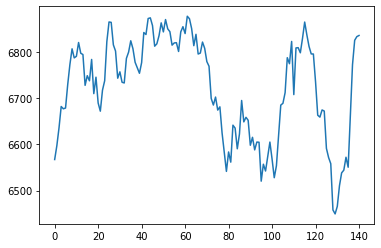

In [4]:
plt.plot(df['ftse'])

**ADF Test**

In [6]:
def adf_test(atr):
    #Perform Dickey-Fuller test:
    timeseries = df[atr].dropna()
    print ('Results of Dickey-Fuller Test for ',atr,'\n')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

#apply adf test on the series
adf_test('ftse')

Results of Dickey-Fuller Test for  ftse 

Test Statistic                  -2.315797
p-value                          0.166924
#Lags Used                       0.000000
Number of Observations Used    140.000000
Critical Value (1%)             -3.477945
Critical Value (5%)             -2.882416
Critical Value (10%)            -2.577902
dtype: float64


ADF test: The test statistic is less than the critical value, so we can reject the null hypothesis. So it is stationary series.
Also P value is approxly 0.05 so, it is stationary.

**KPSS Test**

In [7]:
def kpss_test(atr):
    timeseries = df[atr].dropna()
    print ('Results of KPSS Test for ',atr)
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
kpss_test('ftse')

Results of KPSS Test for  ftse
Test Statistic            0.348183
p-value                   0.099490
Lags Used                14.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


KPSS Test: The test statistic is less than the critical value so we can't reject the null hypothesis. So it is stationary series.


SO from both tests, we can say it is stationary series.

In [9]:
data1 = df.iloc[:,0].values
dataset_array1 = [data1[0::1],data1[0::2],data1[0::4],data1[0::8],data1[0::12],data1[0::24]]

In [10]:
def plotting_function(MSE,MAE,name):
  interval = [1,2,3,4,5,6]

  barWidth = 0.25  
  r1 = np.arange(len(interval))
  r2 = [x + barWidth for x in r1]
  
  # Make the plot
  plt.bar(r1, MSE, color='b', width=barWidth, label='MSE')
  plt.bar(r2, MAE, color='g', width=barWidth, label='MAE')

  plt.xlabel('interval', fontweight='bold')
  plt.xticks([r + barWidth for r in range(len(interval))], ['1', '2', '4', '8', '12','24'])
  plt.title('MSE and MAE plot for '+(name))
  plt.legend()
  plt.show()
 

**single exponential smoothing**

In [11]:
def single_exp(data,interval,alpha):
  array1=data
  
  fv = np.array([None] * len(array1))
  for i in range(interval):
    fv[i]=array1[i]
   
  for i in range(interval, len(array1)):
    fv[i] = alpha * array1[i-interval] + (1 - alpha) * fv[i - interval]
  array = array1-fv
  arr = pd.DataFrame.from_dict({"ftse":array1,"Forecasted value":fv,"Error":array})
  return arr

In [12]:
interval = [1,2,4,8,12,24]
mse1=[]
mae1=[]
for i in interval:
  a = single_exp(df.iloc[:,0],i,0.9)
  mse_val = ((a.Error)**2).sum()/(len(a.Error)-i)
  mae_val = (abs(a.Error)).sum()/(len(a.Error)-i)
  mse1.append(round(mse_val,6))
  mae1.append(round(mae_val,6))

print('MSE for each interval respectively \n',mse1)
print('MSE for each interval respectively \n',mae1)

MSE for each interval respectively 
 [1672.458875, 3568.779268, 7969.041959, 14638.153482, 19277.444792, 21381.6381]
MSE for each interval respectively 
 [31.634948, 46.9068, 70.370794, 93.437646, 107.826145, 121.276231]


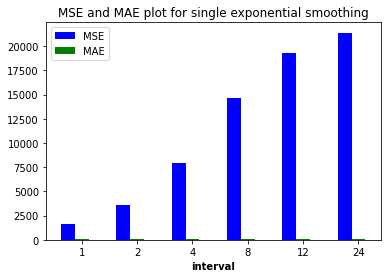

In [13]:
plotting_function(mse1,mae1,'single exponential smoothing')

**Double Exponential Smoothing**

In [14]:
def double_exp(data,interval,alpha,beta):
  array=data
  f = np.array([None] * len(array))
  a = np.array([None] * len(array))
  b = np.array([None] * len(array))
  

  f[0]=data[0]
  a[0] = array[0]
  b[0] = (array[(len(array)-1)] - array[0])/(len(array)-1)

  if interval<2:
    f[1] = a[0]+b[0]
    for i in range(2, len(array)):
      a[i-1] = alpha*array[i-1] + (1-alpha)*(a[i-2]+b[i-2])
      b[i-1] = beta*(a[i-1]-a[i-2]) + (1-beta)*b[i-2]
      f[i] = a[i-1] + b[i-1]
    arr = pd.DataFrame.from_dict({"ftse":array,"Forecasted value":f,"Error":array-f})
  else:
    for i in range(2,interval):
      a[i-1] = alpha*array[i-1] + (1-alpha)*(a[i-2]+b[i-2])
      b[i-1] = beta*(a[i-1]-a[i-2]) + (1-beta)*b[i-2]

    for i in range(1,interval):
      f[i] = a[i-1] + b[i-1]

    for i in range(interval, len(array)):
      a[i-1] = alpha*array[i-1] + (1-alpha)*(a[i-2]+b[i-2])
      b[i-1] = beta*(a[i-1]-a[i-2]) + (1-beta)*b[i-2]
      f[i] = a[i-1] + b[i-1]
    arr = pd.DataFrame.from_dict({"ftse":array,"Forecasted value":f,"Error":array-f})
  return arr

In [15]:
interval = [1,2,4,8,12,24]
mse2=[]
mae2=[]
for i in interval:
  a = double_exp(df.iloc[:,0],i,0.9,0.01)
  mse_val = ((a.Error)**2).sum()/(len(a.Error)-i)
  mae_val = (abs(a.Error)).sum()/(len(a.Error)-i)
  mse2.append(round(mse_val,6))
  mae2.append(round(mae_val,6))

print('MSE for each interval respectively \n',mse2)
print('MSE for each interval respectively \n',mae2)

MSE for each interval respectively 
 [1682.50687, 1694.611236, 1719.350086, 1771.059863, 1825.976448, 2013.256084]
MSE for each interval respectively 
 [31.869107, 32.098381, 32.56697, 33.546428, 34.586627, 38.133974]


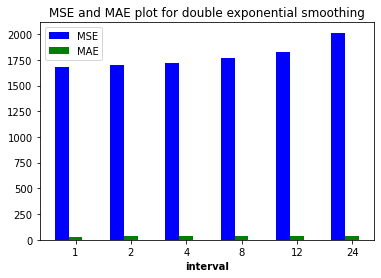

In [16]:
plotting_function(mse2,mae2,'double exponential smoothing')

**Triple Exponential Smoothing**

In [17]:
def initial_trend(data, season_len):
    sum = 0.0
    for i in range(season_len):
        sum += float(data[i+season_len] - data[i]) / season_len
    return sum / season_len

def initial_seasonal(data, season_len):
  seasonals = {}
  season_averages = []
  n_seasons = int(len(data)/season_len)
  # compute season averages
  for j in range(n_seasons):
    avg = ((data[(season_len*j):(season_len*j)+season_len]).sum())/float(season_len)
    season_averages.append(avg)
  # initial values
  for i in range(season_len):
    sum = 0.0
    for j in range(n_seasons):
      sum += data[season_len*j+i]-season_averages[j]
    seasonals[i] = sum/n_seasons
  return seasonals

def triple_exp(data, season_len, alpha, beta, gamma, n_preds):
  result = []
  error = []
  seasonals = initial_seasonal(data, season_len)
  for i in range(len(data)+n_preds):
    if i == 0: # initial values
      smooth = data[0]
      trend = initial_trend(data, season_len)
      result.append(data[0])
      continue
    if i >= len(data): # we are forecasting
      m = i - len(data) + 1
      result.append((smooth + m*trend) + seasonals[i%season_len])
    else:
      val = data[i]
      last_smooth, smooth = smooth, alpha*(val-seasonals[i%season_len]) + (1-alpha)*(smooth+trend)
      trend = beta * (smooth-last_smooth) + (1-beta)*trend
      seasonals[i%season_len] = gamma*(val-smooth) + (1-gamma)*seasonals[i%season_len]
      forecast = smooth+trend+seasonals[i%season_len]
      error = data - forecast
      result.append(forecast)
      
  SE = np.square(error)
  SSE = 0
  for i in SE:
    SSE+= i
  mse_val = SSE/(len(data)-1)
  mae_val = np.sum(abs(error)/len(error))
  return mse_val,mae_val

In [18]:
mse3 = []
mae3 = []
final_forecasted_list = []
for dataframe in dataset_array1:
  mse_val,mae_val = triple_exp(dataframe,1,0.9,0.02,0.95,1)
  mse3.append(round(mse_val,6))
  mae3.append(round(mae_val,6))

print('MSE for each interval respectively \n',mse3)
print('MSE for each interval respectively \n',mae3)

MSE for each interval respectively 
 [26286.024081, 30660.42042, 43527.306202, 30415.754299, 14350.665188, 101794.332426]
MSE for each interval respectively 
 [122.967619, 138.367839, 174.860681, 131.252106, 100.679956, 269.542665]


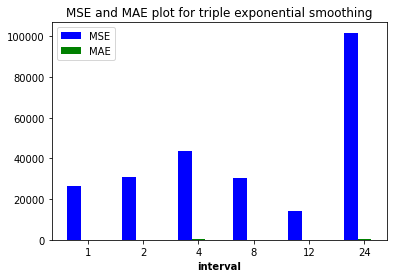

In [19]:
plotting_function(mse3,mae3,'triple exponential smoothing')

**ACF PACF Plot**

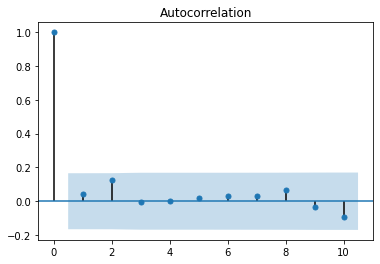

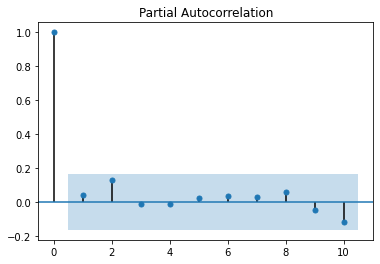

In [20]:
plot_acf(df.iloc[:,1].dropna(), lags=10)
plt.show()
plot_pacf(df.iloc[:,1].dropna(), lags=10)
plt.show()

pmdarima package install

In [21]:
!pip3 install pmdarima

In [22]:
import pmdarima as pm
model = pm.auto_arima(df.iloc[:,0], start_p=1, start_q=1,test='adf',max_p=5, max_q=3,m=1,d=None,seasonal=False,start_P=0, D=0, 
                      trace=True,error_action='ignore',  suppress_warnings=True,stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1439.769, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1437.066, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1438.793, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1438.848, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1435.383, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.509 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  141
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -716.691
Date:                Mon, 01 Mar 2021   AIC                           1435.383
Time:                        06:03:50   BIC                           1438.324
Sample:                             0   HQIC                          1436.578
                                - 141                                       

**AR model**

In [25]:
from statsmodels.tsa.arima_model import ARIMA
def ar_model(data):
  model=ARIMA(data,order=(1,0,0)).fit()
  prediction = model.fittedvalues
  error = data - prediction
  mse_val = np.sum((error)**2)/len(error)
  mae_val = np.sum(abs(error))/len(error)
  return mse_val,mae_val,prediction

In [26]:
mse4 = []
mae4 = []
final_forecasted_list = []
for dataframe in dataset_array1:
  mse_val,mae_val,prediction = ar_model(dataframe)
  mse4.append(round(mse_val,6))
  mae4.append(round(mae_val,6))
  final_forecasted_list.append(prediction)

print('MSE for each interval respectively \n',mse4)
print('MSE for each interval respectively \n',mae4)

MSE for each interval respectively 
 [1730.607587, 3210.008755, 6453.695408, 10696.92366, 11705.442952, 12114.504671]
MSE for each interval respectively 
 [31.415877, 45.041177, 63.757767, 80.411194, 99.169848, 93.264671]


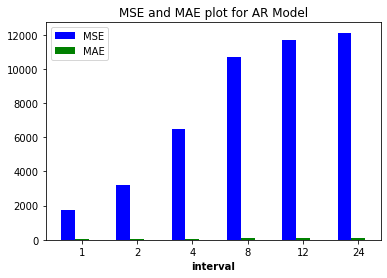

In [27]:
plotting_function(mse4,mae4,'AR Model')

**MA Model**

In [28]:
def ma_model(data):
  model=ARIMA(data,order=(0,0,1)).fit()
  prediction = model.fittedvalues
  error = data - prediction
  mse_val = np.sum((error)**2)/len(error)
  mae_val = np.sum(abs(error))/len(error)
  return mse_val,mae_val,prediction

In [29]:

mse5 = []
mae5 = []
final_forecasted_list = []
for dataframe in dataset_array1:
  mse_val,mae_val,prediction = ma_model(dataframe)
  mse5.append(round(mse_val,6))
  mae5.append(round(mae_val,6))
  final_forecasted_list.append(prediction)

print('MSE for each interval respectively \n',mse5)
print('MSE for each interval respectively \n',mae5)

MSE for each interval respectively 
 [5014.512369, 5273.467598, 7307.293902, 10669.574975, 10118.782027, 10302.931515]
MSE for each interval respectively 
 [60.56038, 60.328257, 66.371851, 81.354384, 93.497286, 92.023897]


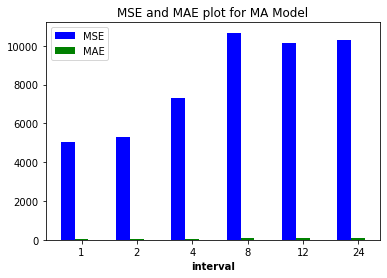

In [30]:
plotting_function(mse5,mae5,'MA Model')

**ARIMA Model**

In [31]:
def arima_model(data):
  model=ARIMA(data,order=(0,1,1)).fit()
  prediction = model.fittedvalues
  data = np.delete(data,[0])
  error = data - prediction
  mse_val = np.sum((error)**2)/len(error)
  mae_val = np.sum(abs(error))/len(error)
  return mse_val,mae_val,prediction

In [32]:
mse6 = []
mae6 = []
final_forecasted_list = []
for dataframe in dataset_array1:
  mse_val,mae_val,prediction = arima_model(dataframe)
  mse6.append(round(mse_val,6))
  mae6.append(round(mae_val,6))
  final_forecasted_list.append(prediction)

print('MSE for each interval respectively \n',mse6)
print('MSE for each interval respectively \n',mae6)

MSE for each interval respectively 
 [45204998.890783, 45168394.212525, 45162378.929808, 45512173.106636, 45236884.038448, 44708347.847302]
MSE for each interval respectively 
 [6722.580322, 6719.947219, 6719.519122, 6744.397919, 6725.209219, 6686.076323]


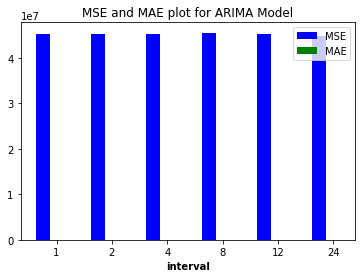

In [33]:
plotting_function(mse6,mae6,'ARIMA Model')